In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re

plt.style.use('seaborn')

# Reading the Zillow Data

### Create Python Package for Allowing Flexibility and Quick Access to Data

In [2]:
zillow_site = requests.get('https://www.zillow.com/research/data/')

In [3]:
zillow_site

<Response [200]>

In [4]:
zillow_site.text[:100]

'\n<!doctype html>\n<html class="no-js" lang="en-US" prefix="og: http://ogp.me/ns#">\n<head>\n<meta chars'

In [5]:
z_df = pd.read_csv("http://files.zillowstatic.com/research/public/Zip/Zip_MedianRentalPrice_AllHomes.csv")

In [6]:
z_df.head()

,RegionName,City,State,Metro,CountyName,SizeRank,2010-02,2010-03,2010-04,2010-05,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05
0,10025,New York,NY,New York,New York,1,NaN,NaN,NaN,NaN,...,3490.0,3405.0,3400.0,3500.0,3500.0,3422.5,3405.0,3400.0,3395.0,3400.0
1,60657,Chicago,IL,Chicago,Cook,2,NaN,NaN,NaN,NaN,...,2000.0,1862.5,1816.0,1800.0,1750.0,1795.0,1750.0,1895.0,1800.0,1850.0
2,10023,New York,NY,New York,New York,3,NaN,NaN,NaN,NaN,...,3700.0,3600.0,3600.0,3698.5,3700.0,3700.0,3525.0,3500.0,3600.0,3562.5
3,75070,McKinney,TX,Dallas-Fort Worth,Collin,4,NaN,NaN,NaN,NaN,...,1850.0,1860.0,1850.0,1850.0,1850.0,1850.0,1850.0,1850.0,1950.0,1895.0
4,77494,Katy,TX,Houston,Harris,5,NaN,NaN,NaN,NaN,...,2100.0,2200.0,2260.0,2200.0,2200.0,2100.0,2100.0,2100.0,2125.0,2150.0


In [7]:
len(z_df)

3203

## Data Exploration - Looking at North Park Rent

In [8]:
North_Park = z_df[z_df['RegionName'] == 92104]

In [9]:
North_Park_melted = pd.melt(North_Park,value_name='RentalPrice',var_name='Date',id_vars=['RegionName','City','State','Metro','CountyName','SizeRank'])

In [10]:
North_Park_melted.head()

,RegionName,City,State,Metro,CountyName,SizeRank,Date,RentalPrice
0,92104,San Diego,CA,San Diego,San Diego,368,2010-02,NaN
1,92104,San Diego,CA,San Diego,San Diego,368,2010-03,NaN
2,92104,San Diego,CA,San Diego,San Diego,368,2010-04,NaN
3,92104,San Diego,CA,San Diego,San Diego,368,2010-05,NaN
4,92104,San Diego,CA,San Diego,San Diego,368,2010-06,NaN


In [11]:
North_Park_melted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 8 columns):
RegionName     100 non-null int64
City           100 non-null object
State          100 non-null object
Metro          100 non-null object
CountyName     100 non-null object
SizeRank       100 non-null int64
Date           100 non-null object
RentalPrice    77 non-null float64
dtypes: float64(1), int64(2), object(5)
memory usage: 6.3+ KB


In [12]:
North_Park_melted['Date'] = pd.to_datetime(North_Park_melted['Date'],format='%Y-%m')
North_Park_melted = North_Park_melted.dropna().set_index('Date')
North_Park_melted.head()

,RegionName,City,State,Metro,CountyName,SizeRank,RentalPrice
Date,,,,,,,
2012-01-01,92104,San Diego,CA,San Diego,San Diego,368,1225.0
2012-02-01,92104,San Diego,CA,San Diego,San Diego,368,1345.0
2012-03-01,92104,San Diego,CA,San Diego,San Diego,368,1200.0
2012-04-01,92104,San Diego,CA,San Diego,San Diego,368,1200.0
2012-05-01,92104,San Diego,CA,San Diego,San Diego,368,1100.0


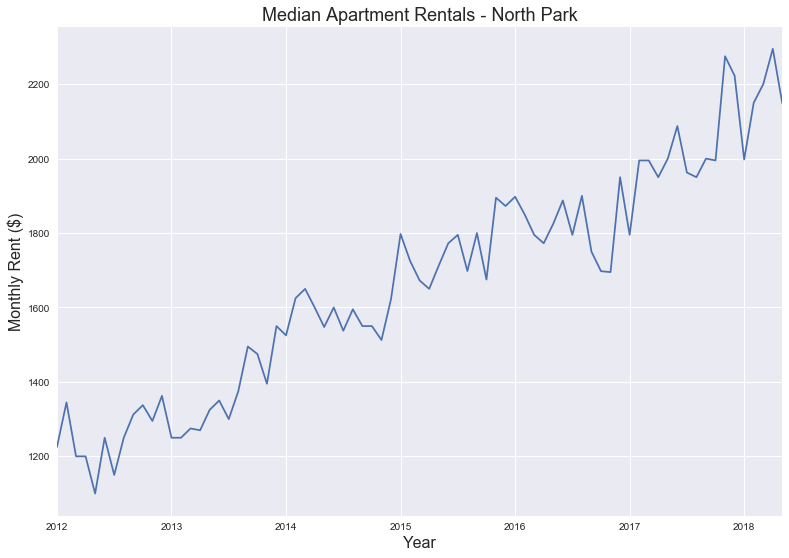

In [13]:
North_Park_melted['RentalPrice'].plot(figsize=(13,9))
plt.title('Median Apartment Rentals - North Park',fontsize=18)
plt.xlabel('Year',fontsize=16)
plt.ylabel('Monthly Rent ($)',fontsize=16)
plt.show()

In [14]:
zhvi_all_homes = pd.read_csv("http://files.zillowstatic.com/research/public/Zip/Zip_Zhvi_AllHomes.csv")

In [15]:
zhvi_all_homes.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05
0,61639,10025,New York,NY,New York,New York,1,171600.0,171600.0,171400.0,...,1101800,1108600,1126300,1142100,1146900,1146000,1143300,1138800,1136300,1136100
1,84654,60657,Chicago,IL,Chicago,Cook,2,158400.0,159700.0,160700.0,...,344900,344500,345600,347400,347800,349200,351500,352400,351000,348900
2,61637,10023,New York,NY,New York,New York,3,347900.0,349600.0,351100.0,...,1608100,1602500,1601300,1597600,1578600,1555300,1535300,1520900,1522100,1537300
3,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,4,235100.0,236300.0,236100.0,...,309000,311600,313400,314400,315500,317700,320100,321500,322200,322900
4,91982,77494,Katy,TX,Houston,Harris,5,210400.0,212200.0,212200.0,...,320600,320200,320500,320900,321100,322600,326200,330000,332400,333800


In [16]:
len(zhvi_all_homes)

15417

In [17]:
zri_all_homes = pd.read_csv("http://files.zillowstatic.com/research/public/Zip/Zip_Zri_AllHomes.csv")

In [18]:
len(zri_all_homes)

15820

In [19]:
zri_all_homes.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,2010-11,2010-12,2011-01,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05
0,61639,10025,New York,NY,New York,New York,1,NaN,NaN,NaN,...,3726,3755,3750,3731,3689,3652,3617,3599,3586,3583
1,84654,60657,Chicago,IL,Chicago,Cook,2,1886.0,1870.0,1846.0,...,2134,2149,2146,2123,2088,2053,2032,2015,2002,1985
2,61637,10023,New York,NY,New York,New York,3,NaN,NaN,NaN,...,4131,4181,4182,4137,4044,3956,3888,3859,3823,3795
3,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,4,1586.0,1583.0,1587.0,...,1948,1951,1950,1945,1937,1925,1916,1910,1909,1906
4,91982,77494,Katy,TX,Houston,Harris,5,2262.0,2261.0,2232.0,...,2252,2252,2248,2243,2243,2245,2247,2248,2249,2250


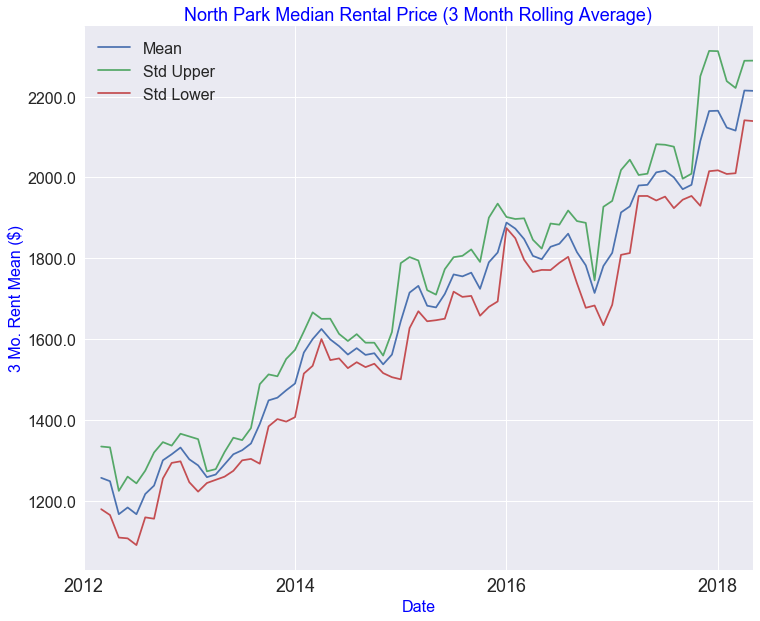

In [20]:
ax = North_Park_melted.rolling(3).mean()['RentalPrice'].plot(figsize=(12,10))

North_Park_melted.rolling(3).std().add(North_Park_melted.rolling(3).mean())['RentalPrice'].plot(ax=ax)

North_Park_melted['RentalPrice'].rolling(3).mean().sub(North_Park_melted['RentalPrice'].rolling(3).std()).plot(ax=ax)

ax.set_xticks(['2012','2014','2016','2018'])
ax.set_xticklabels(['2012','2014','2016','2018'],fontdict={'fontsize':18})
#ax.set_yticks('1200','1400','1600','1800','2000','2200'])
ax.set_yticklabels(ax.get_yticks(),fontdict={'fontsize':16})
ax.set_xlabel('Date',fontsize=16,color='blue')
ax.set_ylabel('3 Mo. Rent Mean ($)',fontsize=16,color='blue')

plt.title('North Park Median Rental Price (3 Month Rolling Average)',fontsize=18,color='blue')
plt.legend(['Mean','Std Upper','Std Lower'],fontsize=16)

plt.show()

- Need to put together a package that allows for selecting the Region Type (e.g. Zip Code, Neighborhood)
- Concatenate dataframes with different rooms, square footage as well. 
- Consider comparing Value vs. Rent, though unclear if it will translate meaningfully. 
- Need to import matplotlib.ticker and format to allow string on the y-axis ($ format)

In [21]:
North_Park_melted['StdLower'] = North_Park_melted['RentalPrice'].rolling(3).mean().sub(North_Park_melted['RentalPrice'].rolling(3).std())
North_Park_melted['StdUpper'] = North_Park_melted['RentalPrice'].rolling(3).mean().add(North_Park_melted['RentalPrice'].rolling(3).std())

In [22]:
North_Park_melted.tail()

,RegionName,City,State,Metro,CountyName,SizeRank,RentalPrice,StdLower,StdUpper
Date,,,,,,,,,
2018-01-01,92104,San Diego,CA,San Diego,San Diego,368,1997.5,2017.584770,2312.415230
2018-02-01,92104,San Diego,CA,San Diego,San Diego,368,2150.0,2008.487422,2238.179245
2018-03-01,92104,San Diego,CA,San Diego,San Diego,368,2200.0,2010.348342,2221.318324
2018-04-01,92104,San Diego,CA,San Diego,San Diego,368,2295.0,2141.345401,2288.654599
2018-05-01,92104,San Diego,CA,San Diego,San Diego,368,2147.5,2139.403151,2288.930183


In [23]:
from statsmodels.graphics import tsaplots

C:\Users\mgavin\Anaconda\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


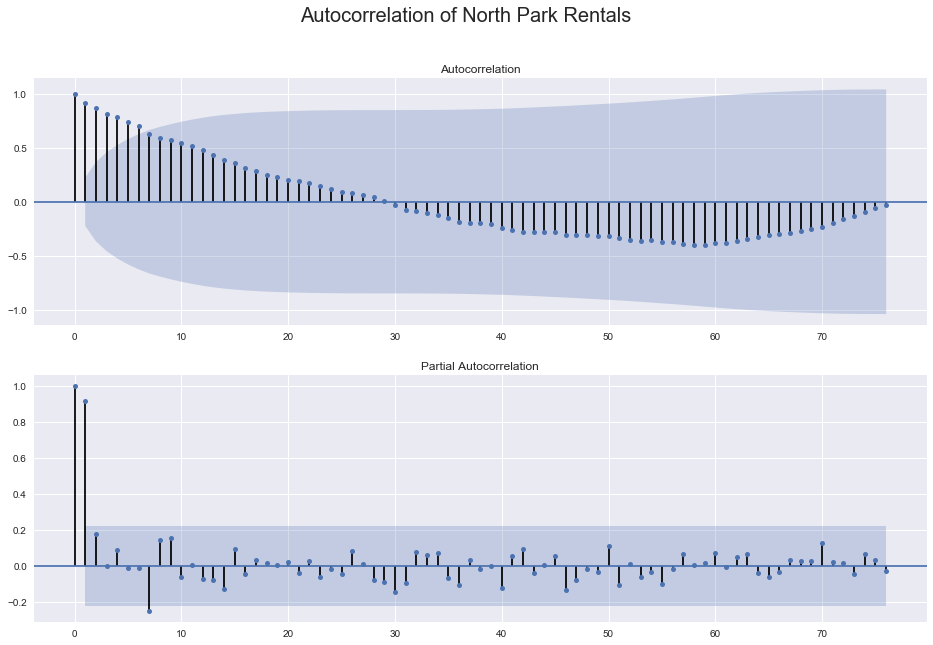

In [24]:
fig, axes = plt.subplots(2,1,figsize=(16,10))

fig.suptitle('Autocorrelation of North Park Rentals',fontsize=20)

tsaplots.plot_acf(North_Park_melted['RentalPrice'],ax=axes[0])

tsaplots.plot_pacf(North_Park_melted['RentalPrice'],ax=axes[1])

plt.show()

### Autocorrelation ###

#### Measures the relation between time point t and previous time points (e.g. t-3) ####

- Based on the ACF graph, there appears to be a correlation between lags 1 through 6
- The PACF graph shows a drop-off, but lag 3 is still significant, which could indicate quarterly trends
- Next is to determine whether there is any seasonality underlying the general upward trend, or if it is mostly noise

In [25]:
def seasonality_monthly(df_input,sampling='M',window='quarterly'):
    

    window_dict = {'quarterly':3,
                   'semiannual':6,
                   'yearly':12}

    quarterly_trends = []
    
    w = window_dict.get(window)

    for i in range(w):
    
        df = pd.DataFrame()
        
        quarterly_trends.append(df.append(df_input.iloc[i::w]))
        
    return quarterly_trends

In [26]:
quarterly_list = seasonality_monthly(North_Park_melted)

In [27]:
quarterly_list

[            RegionName       City State      Metro CountyName  SizeRank  \
 Date                                                                      
 2012-01-01       92104  San Diego    CA  San Diego  San Diego       368   
 2012-04-01       92104  San Diego    CA  San Diego  San Diego       368   
 2012-07-01       92104  San Diego    CA  San Diego  San Diego       368   
 2012-10-01       92104  San Diego    CA  San Diego  San Diego       368   
 2013-01-01       92104  San Diego    CA  San Diego  San Diego       368   
 2013-04-01       92104  San Diego    CA  San Diego  San Diego       368   
 2013-07-01       92104  San Diego    CA  San Diego  San Diego       368   
 2013-10-01       92104  San Diego    CA  San Diego  San Diego       368   
 2014-01-01       92104  San Diego    CA  San Diego  San Diego       368   
 2014-04-01       92104  San Diego    CA  San Diego  San Diego       368   
 2014-07-01       92104  San Diego    CA  San Diego  San Diego       368   
 2014-10-01 

In [28]:
annual_groupings = North_Park_melted.select_dtypes(include=['number']).groupby(North_Park_melted.index.year).mean()

In [29]:
annual_groupings.index = pd.to_datetime(annual_groupings.index,format='%Y')

In [30]:
annual_groupings = annual_groupings.resample('MS',convention='start').ffill()
annual_groupings.head()

,RegionName,SizeRank,RentalPrice,StdLower,StdUpper
Date,,,,,
2012-01-01,92104,368,1252.291667,1181.052482,1303.447518
2012-02-01,92104,368,1252.291667,1181.052482,1303.447518
2012-03-01,92104,368,1252.291667,1181.052482,1303.447518
2012-04-01,92104,368,1252.291667,1181.052482,1303.447518
2012-05-01,92104,368,1252.291667,1181.052482,1303.447518


In [31]:
seasonal_df = pd.concat(quarterly_list,ignore_index=False)

In [32]:
seasonal_df = seasonal_df.sort_index()

In [33]:
seasonal_df = seasonal_df.join(annual_groupings.loc[:,['RentalPrice','StdLower','StdUpper']],lsuffix='_m',rsuffix='_y')

In [34]:
seasonal_df.head()

,RegionName,City,State,Metro,CountyName,SizeRank,RentalPrice_m,StdLower_m,StdUpper_m,RentalPrice_y,StdLower_y,StdUpper_y
Date,,,,,,,,,,,,
2012-01-01,92104,San Diego,CA,San Diego,San Diego,368,1225.0,NaN,NaN,1252.291667,1181.052482,1303.447518
2012-02-01,92104,San Diego,CA,San Diego,San Diego,368,1345.0,NaN,NaN,1252.291667,1181.052482,1303.447518
2012-03-01,92104,San Diego,CA,San Diego,San Diego,368,1200.0,1179.153227,1334.180106,1252.291667,1181.052482,1303.447518
2012-04-01,92104,San Diego,CA,San Diego,San Diego,368,1200.0,1164.617544,1332.049122,1252.291667,1181.052482,1303.447518
2012-05-01,92104,San Diego,CA,San Diego,San Diego,368,1100.0,1108.931640,1224.401694,1252.291667,1181.052482,1303.447518


In [35]:
seasonal_df = seasonal_df.iloc[:,6:]

In [36]:
seasonal_df['RentalPrice_my'] = seasonal_df['RentalPrice_m'] / seasonal_df['RentalPrice_y']
seasonal_df['StdLower_my'] = seasonal_df['StdLower_m'] / seasonal_df['StdLower_y']
seasonal_df['StdUpper_my'] = seasonal_df['StdUpper_m'] / seasonal_df['StdUpper_y']

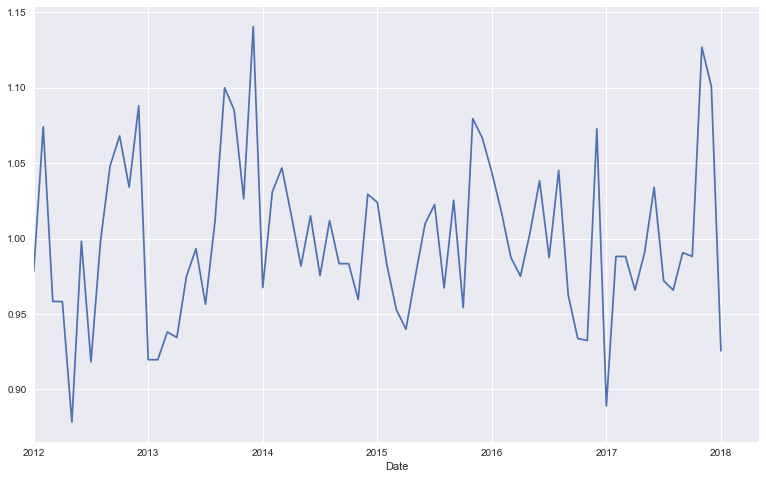

In [37]:
seasonal_df.iloc[:,-3].plot(figsize=(13,8))
plt.show()

In [38]:
quarter_list = []

for index, row in seasonal_df.iterrows():
    
    if index.month in [1,4,7,10]:
        quarter_list.append(1)
        
    elif index.month in [2,5,8,11]:
        quarter_list.append(2)

    else:
        quarter_list.append(3)

        
seasonal_df['QuarterlyGroup'] = quarter_list


In [39]:
seasonal_df.head()

,RentalPrice_m,StdLower_m,StdUpper_m,RentalPrice_y,StdLower_y,StdUpper_y,RentalPrice_my,StdLower_my,StdUpper_my,QuarterlyGroup
Date,,,,,,,,,,
2012-01-01,1225.0,NaN,NaN,1252.291667,1181.052482,1303.447518,0.978207,NaN,NaN,1
2012-02-01,1345.0,NaN,NaN,1252.291667,1181.052482,1303.447518,1.074031,NaN,NaN,2
2012-03-01,1200.0,1179.153227,1334.180106,1252.291667,1181.052482,1303.447518,0.958243,0.998392,1.023578,3
2012-04-01,1200.0,1164.617544,1332.049122,1252.291667,1181.052482,1303.447518,0.958243,0.986084,1.021943,1
2012-05-01,1100.0,1108.931640,1224.401694,1252.291667,1181.052482,1303.447518,0.878390,0.938935,0.939356,2


In [40]:
seasonal_grouped = seasonal_df.groupby(seasonal_df.index.month).mean()

In [41]:
seasonal_grouped.index = pd.to_datetime(seasonal_grouped.index,format='%m').to_period()

seasonal_grouped.head()

,RentalPrice_m,StdLower_m,StdUpper_m,RentalPrice_y,StdLower_y,StdUpper_y,RentalPrice_my,StdLower_my,StdUpper_my,QuarterlyGroup
Date,,,,,,,,,,
1900-01,1641.071429,1621.682334,1812.762110,1705.434524,1628.020070,1761.027549,0.963971,0.951901,0.985636,1
1900-02,1705.714286,1671.786351,1821.269205,1630.006944,1555.451112,1676.215555,1.002179,0.982663,0.992228,2
1900-03,1683.928571,1606.460785,1747.348738,1630.006944,1555.451112,1676.215555,0.978563,0.989673,0.994256,3
1900-04,1676.785714,1645.961453,1731.657595,1630.006944,1555.451112,1676.215555,0.964749,1.002834,0.978416,1
1900-05,1665.357143,1632.542839,1718.171446,1630.006944,1555.451112,1676.215555,0.967508,0.991061,0.967040,2


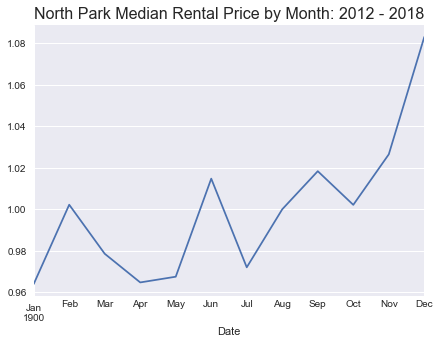

In [42]:
seasonal_grouped['RentalPrice_my'].plot(figsize=(7,5))
plt.title('North Park Median Rental Price by Month: 2012 - 2018',fontsize=16)
plt.show()

- Conclusion from a basic average by month is that rent peaks in December and again in June, for summer rentals

In [43]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [44]:
decomposed_df = seasonal_decompose(seasonal_df.iloc[:,0])

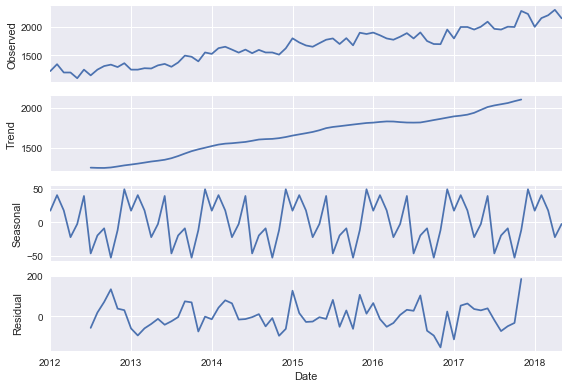

In [45]:
decomposed_df.plot()

- More complicated seasonality emerges here, showing a much lower dip in early fall/October area
- A lot of activity on the residual plot hints that randomness is prevalent

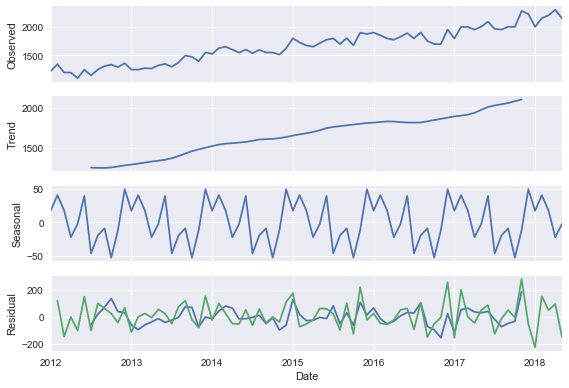

In [46]:
stationary_df = seasonal_df['RentalPrice_m']

#stationary_df = stationary_df.apply(np.log)
stationary_df = stationary_df - stationary_df.shift()
stationary_df.dropna(inplace=True)
stationary_df.plot()

plt.show()

## Testing Stationarity

In [47]:
from statsmodels.tsa.stattools import adfuller

In [48]:
 def test_stationarity(df, print_results=True, **kwargs):
    
    '''Use stattools adfuller function with a more DataFrame-friendly format
    
    df = pandas.DataFrame or pandas.Series: required, used for testing stationarity
    
    **kwargs = dict, used to feed adfuller arguments'''

    raw_results = adfuller(df,**kwargs)
    
    df_rows = {fk: fv for fv, fk in zip(raw_results[:4],list(['Test Statistic','P-Value','Lags Used','Observations Taken']))}
    
    df_rows.update({sk: sv for sk, sv in raw_results[4:-1][0].items()})
    
    
    dickey_test_results = pd.DataFrame(index=df_rows.keys(),data=list(df_rows.values()),columns=['Metric'])
    
    if print_results:
        print('Results of the Augmented Dickey-Fuller Test: \n\n', dickey_test_results.head(10))
    
    return dickey_test_results

In [49]:
dickey_df = test_stationarity(stationary_df,autolag='AIC')

Results of the Augmented Dickey-Fuller Test: 

                        Metric
Test Statistic      -4.718151
P-Value              0.000078
Lags Used            7.000000
Observations Taken  68.000000
1%                  -3.530399
5%                  -2.905087
10%                 -2.590001


### Fortunately, Differencing induced Stationarity

In [50]:
nonstationary_df = seasonal_df['RentalPrice_m']

In [51]:
dickey_df_2 = test_stationarity(nonstationary_df,autolag='AIC')

Results of the Augmented Dickey-Fuller Test: 

                        Metric
Test Statistic      -0.073437
P-Value              0.952021
Lags Used            8.000000
Observations Taken  68.000000
1%                  -3.530399
5%                  -2.905087
10%                 -2.590001


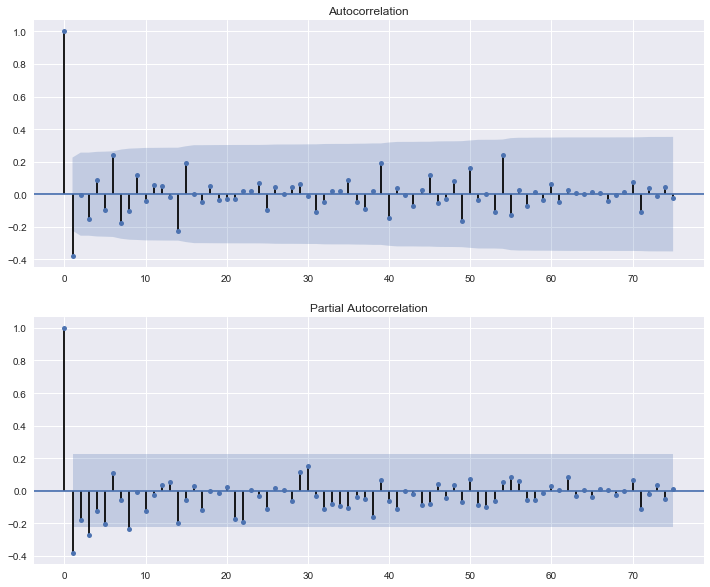

In [52]:
fig, axes = plt.subplots(2,1,figsize=(12,10))

tsaplots.plot_acf(stationary_df,ax=axes[0])
tsaplots.plot_pacf(stationary_df,ax=axes[1])

plt.show()

#### Looks like an AR(1) process at work ###

#### Time to check out the ARIMA model and see if the correlation (roughly -.4) can help us predict future values

In [53]:
new_df = np.cumsum(stationary_df) + seasonal_df.loc[seasonal_df.index.min(),'RentalPrice_m']

In [54]:
from time_series.analysis import *

In [55]:
df, corr = compute_correlation(stationary_df.values,stationary_df.shift(-3))

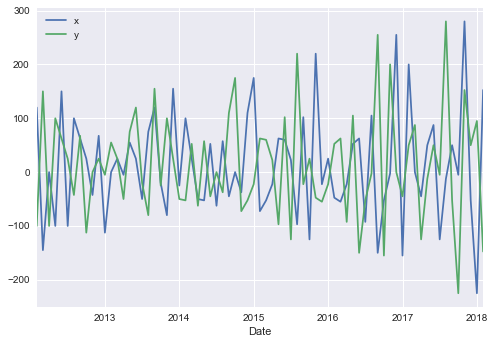

In [56]:
df.iloc[:,:2].plot()
plt.show()

In [57]:
stationary_df.values.reshape(-1).shape

(76,)

In [58]:
def acf_compute(x,y):
    
    if isinstance(x,pd.DataFrame) or isinstance(x,pd.Series):
        
        x = x.dropna().values
        
    if isinstance(y,pd.DataFrame) or isinstance(y,pd.Series):
        
        y = y.dropna().values
        
   # assert ([x.shape()[1],y.shape()[1]].all()) == 1, "Please use 1D array-like object"
        
    nx = len(x)
    ny = len(y)
    
    print(nx,ny)
    x = x[nx-ny:]
    
    print(len(x))
    
    top = np.mean(np.dot((x-np.mean(x)), (y-np.mean(y))))
    
    bot = np.sum(np.square((x-np.mean(x))))
    
    acf_r = top/bot
    
    return acf_r

In [59]:
acf = acf_compute(stationary_df,stationary_df.shift(3))

76 73
73


In [60]:
acf

-0.16208595981637233

In [61]:
auto_corr = autocorrelate(stationary_df,lags=60)

In [62]:
conf_upper = [1.96 / np.sqrt(len(stationary_df)-i) for i in range(len(auto_corr))]
conf_lower = [-1.96 / np.sqrt(len(stationary_df)-i) for i in range(len(auto_corr))]

In [63]:
conf_upper[:5]

[0.2248274191931505,
 0.22632130552233326,
 0.22784537193788579,
 0.22940064850441591,
 0.23098821518760554]

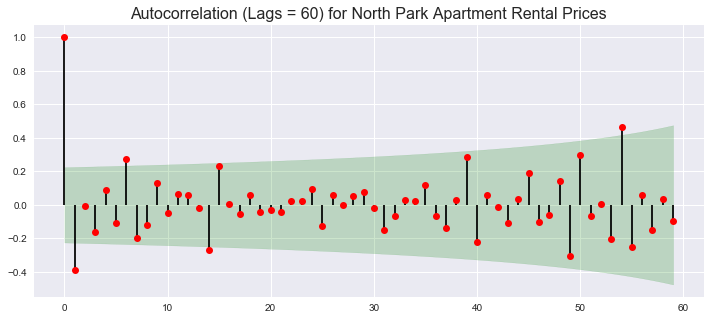

In [64]:
plt.figure(figsize=(12,5))

plt.plot(auto_corr,linestyle='none',marker='o',color='red')

for i, x in enumerate(auto_corr):
    plt.vlines(x=i,ymin=min(0,x),ymax=max(0,x))
    
plt.fill_between([i for i in range(len(auto_corr))],conf_lower,conf_upper,color='green',alpha=0.2)

plt.title('Autocorrelation (Lags = {}) for North Park Apartment Rental Prices'.format(len(auto_corr)),fontsize=16)

plt.show()

### Voila! A custom Autocorrelation function that resembles statsmodels acf function:

In [65]:
corr_5 = autocorrelate(stationary_df,lags=5)

In [66]:
corr_5

array([ 1.        , -0.38629415, -0.00745552, -0.16208596,  0.09039718])

In [67]:
from statsmodels.tsa.stattools import acf, acovf

In [68]:
acf(stationary_df)

array([ 1.        , -0.38042803, -0.00701846, -0.15401088,  0.08399977,
       -0.09731942,  0.2416689 , -0.17616845, -0.10313375,  0.11571255,
       -0.04231915,  0.05504936,  0.04938504, -0.01751818, -0.22932044,
        0.1944781 ,  0.00176369, -0.04742051,  0.05000737, -0.03480717,
       -0.02696748, -0.03255724,  0.01974795,  0.01728264,  0.07136713,
       -0.09827094,  0.04501505, -0.00191612,  0.04167069,  0.0595518 ,
       -0.01308406, -0.1127118 , -0.04791788,  0.02205988,  0.01844162,
        0.08436045, -0.04649773, -0.09331275,  0.02093371,  0.18937102,
       -0.14805007])

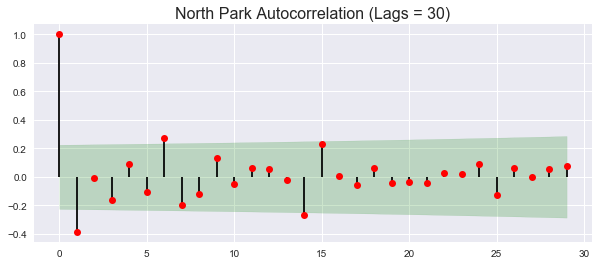

In [69]:
plt.figure(figsize=(10,4))

plot_auto_corr(stationary_df,title='North Park Autocorrelation',lags=30)

In [70]:
autocorrelate(stationary_df,conf_int=True,lags=30)

(array([ 1.        , -0.38629415, -0.00745552, -0.16208596,  0.09039718,
        -0.10732187,  0.27083092, -0.20008135, -0.11762561,  0.13201118,
        -0.04843252,  0.06340716,  0.05831799, -0.02055749, -0.27096664,
         0.22978051,  0.00249003, -0.05623692,  0.06061505, -0.04128392,
        -0.03312167, -0.03990491,  0.02481686,  0.02228206,  0.09209887,
        -0.12885002,  0.0587921 , -0.00247298,  0.05526536,  0.07936511]),
 array([ 0.22482742,  0.22632131,  0.22784537,  0.22940065,  0.23098822,
         0.23260921,  0.23426481,  0.23595627,  0.23768491,  0.23945211,
         0.24125932,  0.24310808,  0.245     ,  0.24693679,  0.24892025,
         0.25095228,  0.25303491,  0.25517027,  0.25736061,  0.25960834,
         0.26191602,  0.26428635,  0.26672222,  0.26922671,  0.2718031 ,
         0.2744549 ,  0.27718586,  0.28      ,  0.28290163,  0.28589538]),
 array([-0.22482742, -0.22632131, -0.22784537, -0.22940065, -0.23098822,
        -0.23260921, -0.23426481, -0.23595627, 

### Now that we have figured out the ACF, Let's get to actual predictions

In [71]:
from statsmodels.tsa.arima_model import ARIMA

In [72]:
arima = ARIMA(stationary_df,order=(2,0,1))

In [73]:
fitted_arima = arima.fit()

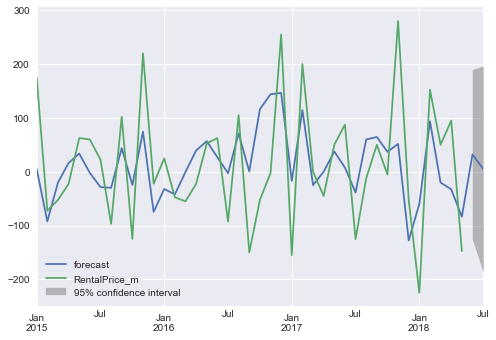

In [74]:
fitted_arima.plot_predict(start='2015-01-01',end='2018-07-01')

In [75]:
fitted_arima.forecast()

(array([ 32.12117894]),
 array([ 80.37808075]),
 array([[-125.41696449,  189.65932236]]))

# Zooming out: Looking at the Bigger Picture #

* Build a tool that allows for time series analysis on different zip codes 
* Comparison between neighborhoods, do different AR-MA models explain different parts of the country?

In [106]:
from zipfile import ZipFile

In [203]:
from urllib.request import urlretrieve
from itertools import chain

In [176]:
list_of_geographies = ['State','Metro','County','City','Zip','Neighborhood']

In [179]:
zip_list = []

for g in list_of_geographies:
    zip_list.append(ZipFile(urlretrieve('http://files.zillowstatic.com/research/public/{}.zip'.format(g),'{}.zip'.format(g))[0],'r'))

In [212]:
csv_list_rental = []

for i in zip_list:
    x = i.namelist()
    csv_list_rental.append(sorted(list(chain.from_iterable([re.findall('.+MedianRentalPrice.+',z) for z in x]))))
    

In [226]:
csv_list_rental

[['State/State_MedianRentalPricePerSqft_1Bedroom.csv',
  'State/State_MedianRentalPricePerSqft_2Bedroom.csv',
  'State/State_MedianRentalPricePerSqft_3Bedroom.csv',
  'State/State_MedianRentalPricePerSqft_4Bedroom.csv',
  'State/State_MedianRentalPricePerSqft_5BedroomOrMore.csv',
  'State/State_MedianRentalPricePerSqft_AllHomes.csv',
  'State/State_MedianRentalPricePerSqft_CondoCoop.csv',
  'State/State_MedianRentalPricePerSqft_DuplexTriplex.csv',
  'State/State_MedianRentalPricePerSqft_Mfr5Plus.csv',
  'State/State_MedianRentalPricePerSqft_Sfr.csv',
  'State/State_MedianRentalPricePerSqft_Studio.csv',
  'State/State_MedianRentalPrice_1Bedroom.csv',
  'State/State_MedianRentalPrice_2Bedroom.csv',
  'State/State_MedianRentalPrice_3Bedroom.csv',
  'State/State_MedianRentalPrice_4Bedroom.csv',
  'State/State_MedianRentalPrice_5BedroomOrMore.csv',
  'State/State_MedianRentalPrice_AllHomes.csv',
  'State/State_MedianRentalPrice_CondoCoop.csv',
  'State/State_MedianRentalPrice_DuplexTriplex.

In [269]:
dict_list = []

for i in csv_list_rental:
    
    dict_index = i[0].split('/')[0]
    
    dict_list.append({dict_index: [x.split('/')[1] for x in i]})
        
    print(dict_index)

State
Metro
County
City
Zip
Neighborhood


In [270]:
dict_list

[{'State': ['State_MedianRentalPricePerSqft_1Bedroom.csv',
   'State_MedianRentalPricePerSqft_2Bedroom.csv',
   'State_MedianRentalPricePerSqft_3Bedroom.csv',
   'State_MedianRentalPricePerSqft_4Bedroom.csv',
   'State_MedianRentalPricePerSqft_5BedroomOrMore.csv',
   'State_MedianRentalPricePerSqft_AllHomes.csv',
   'State_MedianRentalPricePerSqft_CondoCoop.csv',
   'State_MedianRentalPricePerSqft_DuplexTriplex.csv',
   'State_MedianRentalPricePerSqft_Mfr5Plus.csv',
   'State_MedianRentalPricePerSqft_Sfr.csv',
   'State_MedianRentalPricePerSqft_Studio.csv',
   'State_MedianRentalPrice_1Bedroom.csv',
   'State_MedianRentalPrice_2Bedroom.csv',
   'State_MedianRentalPrice_3Bedroom.csv',
   'State_MedianRentalPrice_4Bedroom.csv',
   'State_MedianRentalPrice_5BedroomOrMore.csv',
   'State_MedianRentalPrice_AllHomes.csv',
   'State_MedianRentalPrice_CondoCoop.csv',
   'State_MedianRentalPrice_DuplexTriplex.csv',
   'State_MedianRentalPrice_Mfr5Plus.csv',
   'State_MedianRentalPrice_Sfr.csv',

- A list of Dicts to make it easier for combining and finding patterns across different geographic regions

In [283]:
list(chain.from_iterable(list(dict_list[-1].values())))[-1]

'Neighborhood_MedianRentalPrice_Studio.csv'